In [1]:
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import zipfile
import os

def extract_zip_from_drive(zip_path, extract_to='.'):
    # Extract ZIP file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"ZIP file extracted to {extract_to}")

# Example usage
# Specify the relative path to the ZIP file in Google Drive (e.g., 'myfolder/myfile.zip')
# and the directory where you want it to be extracted.
extract_zip_from_drive('/content/drive/MyDrive/SIS421/NLP/ReglamentoUniversitario.zip', '/content/reglamentoUniversitario')


ZIP file extracted to /content/reglamentoUniversitario


In [6]:
from torch.utils.data import random_split

In [7]:
class ChunkedDocumentDataset(Dataset):
    def __init__(self, root_dir, tokenizer, chunk_size=256, stride=128, max_length=512):
      #       """
      # root_dir: El directorio donde están los archivos de texto organizados por categoría (cada subdirectorio representa una categoría o etiqueta).
      # tokenizer: Una instancia de un tokenizador (como los de la biblioteca transformers de Hugging Face) para convertir el texto en tokens que el modelo puede usar.
      # chunk_size: Tamaño de cada fragmento de texto, en tokens o palabras.
      # stride: Mantener el contexto, cada fragmento comparte 128 tokens
      # max_length: La longitud máxima de tokens para cada fragmento después de tokenizar.
      # """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.chunk_size = chunk_size
        self.stride = stride
        self.documents = []
        self.labels = []

        encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252'] #lista para manejar distintos tipo de codificacion

        for root, dirs, files in os.walk(root_dir):
            category = os.path.basename(root)
            for file in files:
                if file.endswith('.txt'):
                    file_path = os.path.join(root, file)

                    for encoding in encodings:
                        try:
                            with open(file_path, 'r', encoding=encoding) as f:
                                text = f.read()
                                # Split text into chunks
                                words = text.split()
                                for i in range(0, len(words), self.stride):
                                    chunk = ' '.join(words[i:i + self.chunk_size])
                                    if len(chunk.split()) > 50:  # Only keep chunks with sufficient content
                                        self.documents.append(chunk)
                                        self.labels.append(category)
                                break
                        except UnicodeDecodeError:
                            continue
                        except Exception as e:
                            print(f"Error reading {file_path}: {str(e)}")
                            break

        self.unique_labels = list(set(self.labels)) #extraemos las categorias y las convertimos a etiquietas enteras
        self.label_to_id = {label: idx for idx, label in enumerate(self.unique_labels)}

    def __len__(self):
        return len(self.documents)

    def __getitem__(self, idx):
        text = self.documents[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text, #fragmento de texto a ser tokenizdado
            truncation=True, # Si el texto es demasiado largo (más de max_length), se recortará para ajustarse al límite.
            max_length=self.max_length, # Define la longitud máxima de tokens permitidos.
            padding='max_length', #se anaden tokens de relleno si no llega a alcanzar la longitud necesaria
            return_tensors='pt' #convierte a tensores de pytorch
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0), # U: Los IDs de los tokens en forma de tensor. .elimina una dimension
            'attention_mask': encoding['attention_mask'].squeeze(0),# U: palabras reales (1) y cuáles son solo relleno (0)..elimina una dimension
            'label': torch.tensor(self.label_to_id[label]) #id en forma de tensor
        }

In [8]:
def create_split_dataloaders(root_dir, batch_size=8, train_split=0.8, val_split=0.1):
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    # BertTokenizer.from_pretrained carga el tokenizador del modelo BERT, entrenado para manejar
    # múltiples idiomas (modelo bert-base-multilingual-cased), lo cual permite trabajar con texto en diferentes idiomas.
    dataset = ChunkedDocumentDataset(root_dir, tokenizer)
    # Aquí se inicializa una instancia de ChunkedDocumentDataset, pasando el directorio de los datos
    #  (root_dir) y el tokenizador (tokenizer).
    # Esto prepara el conjunto de datos para ser dividido en fragmentos y tokenizado.

    # Calculate split sizes
    total_size = len(dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size

    # Split dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset,
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )

    return {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        'val': DataLoader(val_dataset, batch_size=batch_size),
        'test': DataLoader(test_dataset, batch_size=batch_size)
    }, dataset.unique_labels, tokenizer

In [11]:
dataloaders, categories, tokenizer = create_split_dataloaders(
    "/content/reglamentoUniversitario/ReglamentoUniversitario",
    batch_size=8,
    train_split=0.8,
    val_split=0.1
)

print(f"Number of categories: {len(categories)}")
print("Dataset sizes:")
print(f"Train: {len(dataloaders['train'].dataset)}")
print(f"Validation: {len(dataloaders['val'].dataset)}")
print(f"Test: {len(dataloaders['test'].dataset)}")

Number of categories: 7
Dataset sizes:
Train: 725
Validation: 90
Test: 92


In [12]:
from torch import nn
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
from pathlib import Path
import time
from transformers import get_linear_schedule_with_warmup, BertModel

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0):
        self.patience = patience #Número de épocas que el modelo puede continuar entrenándose sin mejorar. Si no hay mejora en la pérdida después de este número de épocas, el entrenamiento se detendrá.
        self.min_delta = min_delta #Mínima mejora requerida para que se considere que hay progreso. Si la mejora en la pérdida, se incrementa
        self.counter = 0 #Contador que lleva la cuenta de cuántas épocas consecutivas no ha habido una mejora significativa
        self.best_loss = None #Almacena el mejor valor de pérdida observado hasta el momento durante el entrenamiento.
        self.early_stop = False # Indicador booleano de si debe detenerse el entrenamiento.

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience: #se activa early stopping
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

La clase RegulationsTransformer utiliza BERT para transformar texto en una representación densa y luego usa una red completamente conectada para clasificar esta representación en num_labels categorías.

2. Preentrenamiento de BERT

BERT se entrena previamente en grandes cantidades de texto con dos tareas principales que ayudan a capturar significados y relaciones complejas:

Masked Language Modeling (MLM): en esta tarea, BERT enmascara (oculta) aleatoriamente el 15% de las palabras en una oración y trata de predecir estas palabras ocultas. Esto obliga a BERT a aprender el contexto completo en ambos sentidos, ya que debe inferir una palabra basándose en las palabras que la rodean.

Next Sentence Prediction (NSP): BERT también se entrena para entender las relaciones entre pares de oraciones. En esta tarea, recibe dos oraciones y debe predecir si la segunda oración sigue a la primera en el texto original o si son oraciones aleatorias. Esto ayuda a BERT a comprender mejor cómo se relacionan las ideas en el texto.

3. Tokenización en BERT

BERT usa una técnica de tokenización llamada WordPiece. Esta tokenización divide las palabras en subpalabras o morfemas (piezas de palabras). Esto permite a BERT manejar vocabularios más grandes y entender palabras que nunca ha visto antes en contextos específicos.

Ejemplo: La palabra "jugando" podría dividirse en "jug" y "ando", y BERT podrá comprender las partes y su significado en contextos específicos.
4. Fine-tuning (Ajuste Fino)

Después del preentrenamiento, BERT se puede ajustar para tareas específicas, como clasificación de texto, análisis de sentimiento, reconocimiento de entidades, etc. En este paso, se añaden capas adicionales al modelo BERT y se entrena en un conjunto de datos etiquetado para esa tarea específica.
5. Salida de BERT

Cuando BERT procesa una entrada, produce dos tipos de salidas principales:
Embeddings de los tokens: para cada token en la entrada, BERT genera un vector de características que representa su significado en el contexto de la oración.
    Pooler Output: representa el significado de la oración completa y se utiliza para tareas de clasificación de texto.

    
Ejemplo de Funcionamiento

Supongamos que queremos que BERT entienda el contexto de la palabra "banco" en la frase "me senté en el banco de la plaza". La autoatención permitirá que BERT vea palabras como "senté" y "plaza", lo que ayuda a deducir que "banco" en este contexto probablemente se refiere a un asiento, no a una institución financiera.
Resumen

BERT es un modelo poderoso que comprende el contexto en ambas direcciones de una oración, logrando así una comprensión profunda del texto. Esto es útil en múltiples tareas de procesamiento de lenguaje natural, donde es importante entender no solo las palabras individuales sino también cómo interactúan en contextos más amplios.

In [15]:
class RegulationsTransformer(nn.Module):
    def __init__(self, num_labels, freeze_bert=True):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased') #Permite trabajar con otros idiomas

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False #permite que los pesos no se acualicen durante el entrenamiento

        self.classifier = nn.Sequential( #permite realizar la clasificacion fc conecta la salida de Bert con nuestra clasificacion
            nn.Linear(self.bert.config.hidden_size, 512), #sta capa lineal reduce la salida de BERT (768 dimensiones para BERT base) a 512 dimensiones.
            nn.ReLU(),
            nn.Dropout(0.1), #desactivar aleatoriamente el 10% de las neuronas durante el entrenamiento.
            nn.Linear(512, num_labels) #educe la dimensionalidad de 512 al número de etiquetas num_labels.
        )

    def forward(self, input_ids, attention_mask): # define cómo los datos fluyen a través del modelo
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) #Llama a BERT usando input_ids (IDs de los tokens del texto)
        # y attention_mask (indica qué tokens son reales y cuáles son padding)
        pooled_output = outputs.pooler_output #Extrae pooler_output, que representa la oración completa y
        # suele estar en la primera posición de la salida de BERT
        return self.classifier(pooled_output) # Pasa pooled_output a través de la capa de clasificación para generar la predicción final.

La clase TransferLearningTrainer es un componente clave para entrenar un modelo de aprendizaje por transferencia. Recibe un modelo preentrenado, lo ajusta para una tarea específica, y maneja aspectos como el optimizador, la programación de la tasa de aprendizaje y el guardado de los mejores modelos durante el entrenamiento. Además, se ocupa de la organización de las métricas y el seguimiento del rendimiento del modelo.

In [11]:
class TransferLearningTrainer:
    def __init__(self, model, dataloaders, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model
        self.dataloaders = dataloaders
        self.device = device
        self.model.to(device)

        # Se inicializan listas vacías para almacenar las pérdidas (losses) y las precisiones (accuracies)
        #tanto del conjunto de entrenamiento como del de validación.
        self.train_losses = []
        self.val_losses = []
        self.train_accs = []
        self.val_accs = []

        # Initialize checkpoint directory
        self.checkpoint_dir = Path('/content/drive/MyDrive/SIS421/NLP/CheckpointClasificador')
        self.checkpoint_dir.mkdir(exist_ok=True)

        bert_params = list(model.bert.parameters())
        classifier_params = list(model.classifier.parameters())

        self.optimizer = torch.optim.AdamW([
            {'params': bert_params, 'lr': 2e-5},
            {'params': classifier_params, 'lr': 1e-3}
        ])
#         bert_params: los parámetros del modelo BERT. Se le asigna una tasa de aprendizaje pequeña (2e-5), porque BERT ya
#         está preentrenado y no queremos modificar sus pesos demasiado rápido.
# classifier_params: los parámetros de la capa de clasificación que se añadió al modelo. Este conjunto de parámetros tiene una
# tasa de aprendizaje mayor (1e-3), ya que esta parte del modelo es nueva y se necesita aprender más rápido.

        num_training_steps = len(dataloaders['train']) * 10
        num_warmup_steps = num_training_steps // 10 # tasa de aprendizaje aumenta gradualmente. Aquí, es el 10% de los pasos totales.

        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=num_warmup_steps,
            num_training_steps=num_training_steps
        )

        self.criterion = nn.CrossEntropyLoss() #funcion de perdida

    def train_epoch(self, epoch):
        self.model.train() #Esto indica que el modelo se encuentra en modo de entrenamiento. En este modo, ciertas capas del modelo,
        #como el Dropout y la normalización por lotes (BatchNorm), se comportan de manera diferente que en el modo de evaluación (eval()).

        total_loss = 0
        correct = 0
        total = 0

        pbar = tqdm(self.dataloaders['train'], desc=f'Epoch {epoch}') #se crea la barra de progreso
        for batch in pbar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['label'].to(self.device)

            self.optimizer.zero_grad()
            outputs = self.model(input_ids, attention_mask) #el modelo realiza una predicción, tomando como entrada los input_ids y attention_mask.
            loss = self.criterion(outputs, labels) #se calcula la perdida
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)#Esta línea se asegura de que los gradientes
            #no se vuelvan demasiado grandes, lo que podría llevar a un exploding gradient.
            #Limita la norma de los gradientes a un valor máximo de 1.0.

            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item() #: se acumula la pérdida de la iteración actual.
            _, predicted = torch.max(outputs, 1) #se obtiene la clase predicha. torch.max devuelve dos valores: los valores máximos y sus índices
            total += labels.size(0) # se cuenta el número de predicciones correctas comparando las predicciones con las etiquetas verdaderas.
            correct += (predicted == labels).sum().item() #: actualiza la barra de progreso con información sobre la pérdida

            pbar.set_postfix({ #actualiza la barra de progreso con información sobre la pérdida (loss),
                              #la precisión (acc), y la tasa de aprendizaje actual (lr).
                'loss': total_loss / (pbar.n + 1),
                'acc': 100 * correct / total,
                'lr': self.scheduler.get_last_lr()[0]
            })

        return total_loss / len(self.dataloaders['train']), 100 * correct / total #perdida promedio, preciison promedio

    def validate(self):
        self.model.eval() #Dropout y la normalización por lotes (BatchNorm se comportan diferente
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad(): #iteracion sobre los lotes del conjunto de validacion
            for batch in self.dataloaders['val']:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['label'].to(self.device)

                # pasa los input_ids y attention_mask al modelo para obtener las predicciones (outputs).
                outputs = self.model(input_ids, attention_mask)
                # calcula la pérdida entre las predicciones (outputs) y las etiquetas verdaderas (labels),
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                #torch.max devuelve dos valores: los valores máximos y sus índices.
                # El primer valor se ignora con _ y se guarda el índice (predicted), que es la clase predicha.
                total += labels.size(0)
                correct += (predicted == labels).sum().item()#cuenta el número de predicciones correctas.
                #Compara las predicciones (predicted) con las etiquetas verdaderas (labels) y suma los valores correctos.

        return total_loss / len(self.dataloaders['val']), 100 * correct / total

    def train(self, epochs=10, patience=7):
        best_val_loss = float('inf')
        counter = 0 #early stopping contador

        for epoch in range(epochs):
            train_loss, train_acc = self.train_epoch(epoch) #Se obtienen la pérdida y la precisión del modelo
            # para el conjunto de entrenamiento de la época actual
            self.train_losses.append(train_loss)
            self.train_accs.append(train_acc)

            val_loss, val_acc = self.validate() # obtienen la pérdida y la precisión en el conjunto de
            #validación de la época actual mediante el método validate.
            self.val_losses.append(val_loss)
            self.val_accs.append(val_acc)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0
                self.save_checkpoint(epoch, is_best=True)
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping at epoch {epoch}")
                    break

            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
                  f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            self.plot_progress()

    def plot_progress(self):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Val Loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.train_accs, label='Train Acc')
        plt.plot(self.val_accs, label='Val Acc')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def save_checkpoint(self, epoch, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accs': self.train_accs,
            'val_accs': self.val_accs
        }

        if is_best:
            torch.save(checkpoint, self.checkpoint_dir / 'best_model.pt')
        else:
            torch.save(checkpoint, self.checkpoint_dir / f'checkpoint_clasificadorTexto_epoch_{epoch}_NOV15.pt')

    def fine_tune_bert(self):
        for param in self.model.bert.parameters(): #obtienes acceso a la instancia de BERT dentro de tu modelo, lo cual contiene los parámetros (pesos y sesgos) del modelo preentrenado
            param.requires_grad = True# Al configurar requires_grad como True, indicas que estos parámetros deben ser ajustados durante el entrenamiento.
            #Esto significa que durante el proceso de retropropagación (backpropagation)


model.safetensors:  23%|##3       | 168M/714M [00:00<?, ?B/s]

Epoch 0:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 0: Train Loss: 1.8075, Train Acc: 28.69%, Val Loss: 1.5353, Val Acc: 44.44%


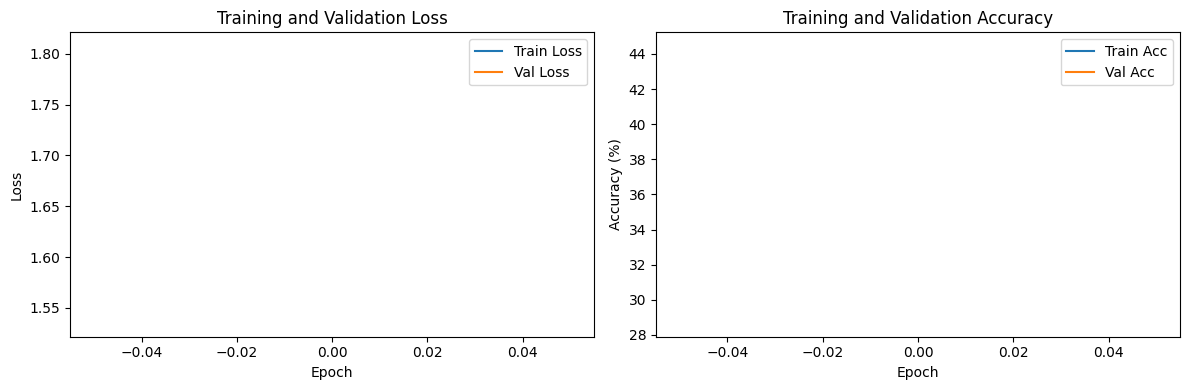

Epoch 1:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1: Train Loss: 1.4853, Train Acc: 44.69%, Val Loss: 0.8896, Val Acc: 67.78%


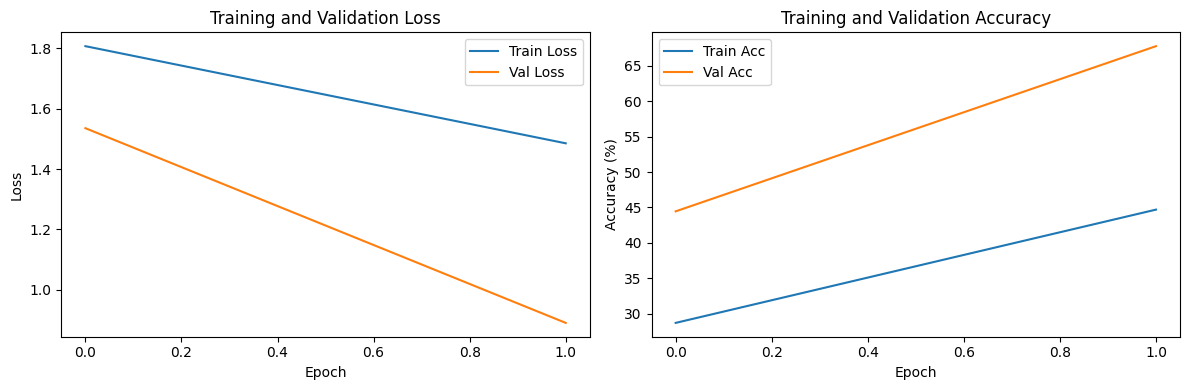

Epoch 2:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2: Train Loss: 0.6380, Train Acc: 79.31%, Val Loss: 0.2981, Val Acc: 92.22%


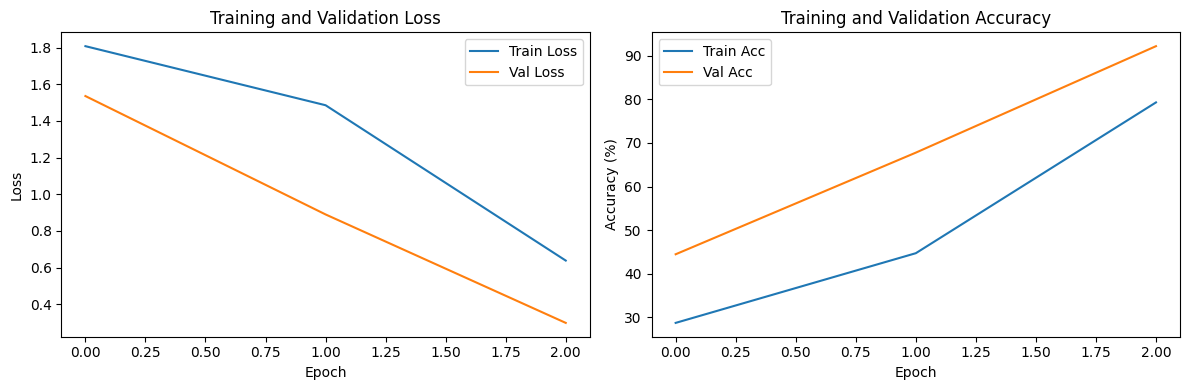

Epoch 3:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3: Train Loss: 0.3154, Train Acc: 89.52%, Val Loss: 0.1681, Val Acc: 96.67%


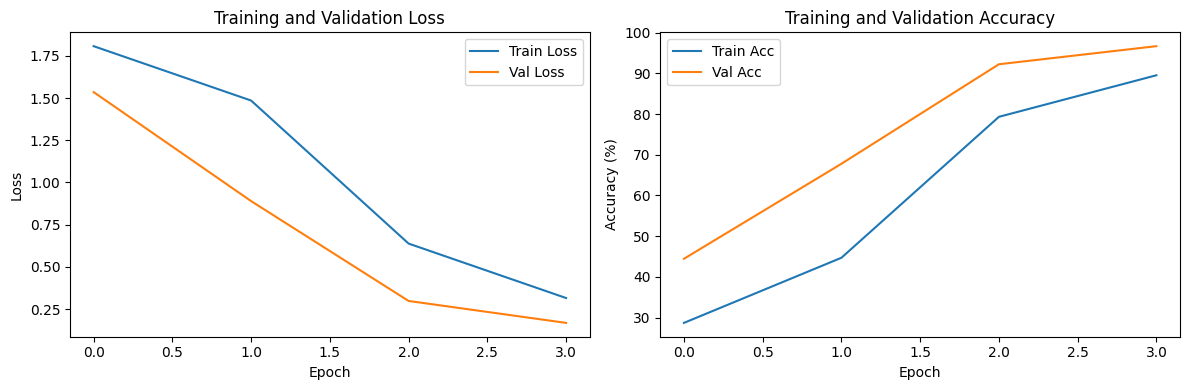

Epoch 4:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4: Train Loss: 0.1597, Train Acc: 96.28%, Val Loss: 0.2367, Val Acc: 94.44%


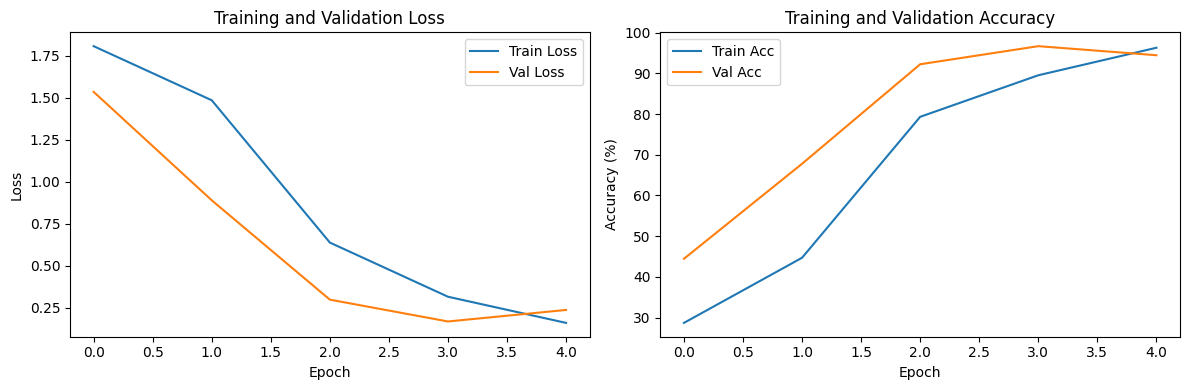

Epoch 5:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5: Train Loss: 0.0847, Train Acc: 97.79%, Val Loss: 0.0329, Val Acc: 96.67%


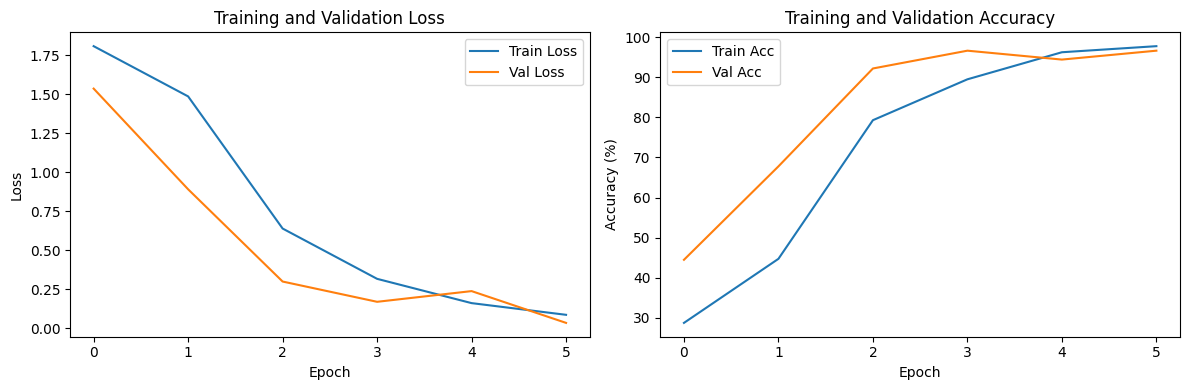

Epoch 6:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6: Train Loss: 0.0384, Train Acc: 99.17%, Val Loss: 0.1137, Val Acc: 97.78%


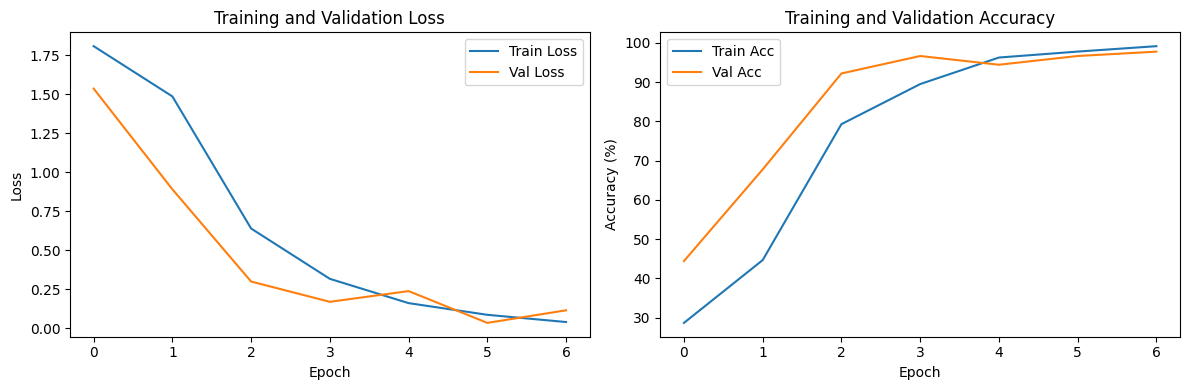

Epoch 7:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7: Train Loss: 0.0140, Train Acc: 99.72%, Val Loss: 0.1326, Val Acc: 97.78%


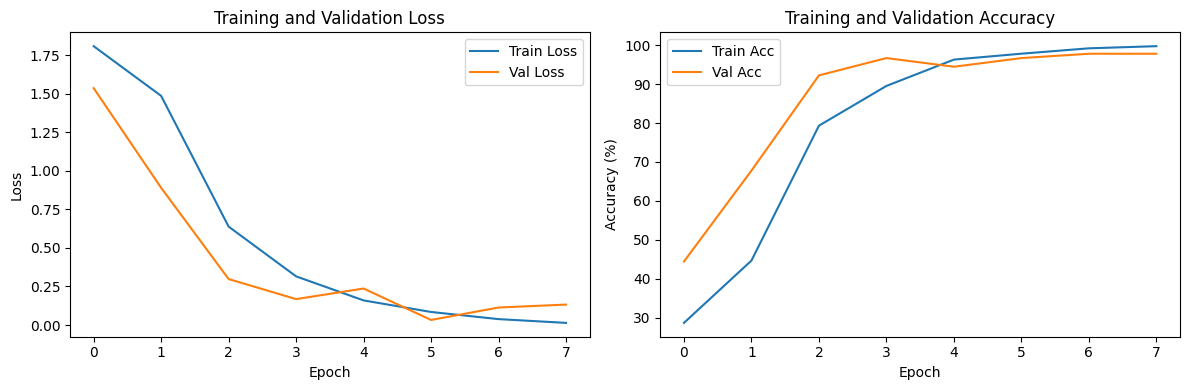

Epoch 8:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8: Train Loss: 0.0058, Train Acc: 99.86%, Val Loss: 0.1581, Val Acc: 97.78%


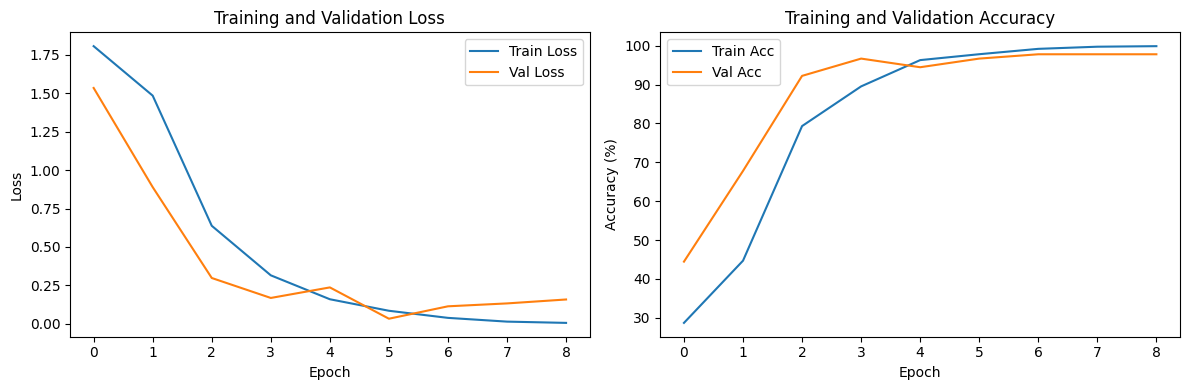

Epoch 9:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9: Train Loss: 0.0064, Train Acc: 99.86%, Val Loss: 0.1495, Val Acc: 96.67%


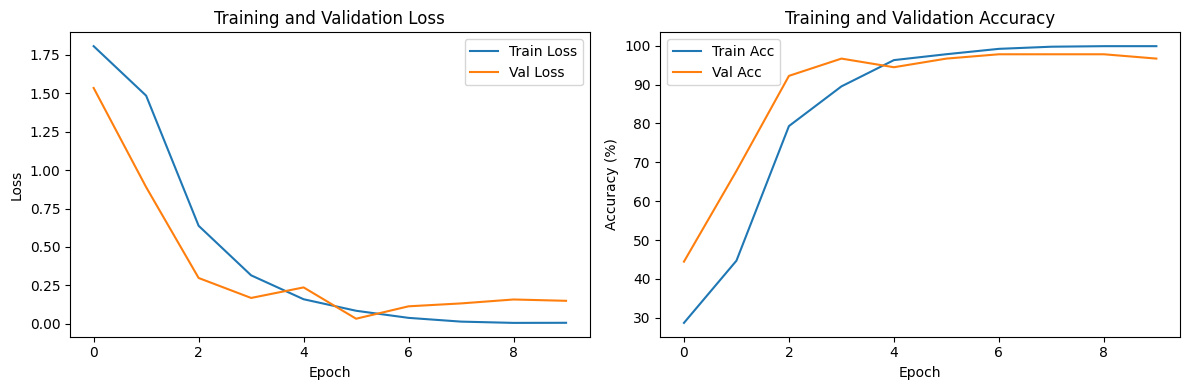

Epoch 10:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10: Train Loss: 0.0047, Train Acc: 99.86%, Val Loss: 0.1495, Val Acc: 96.67%


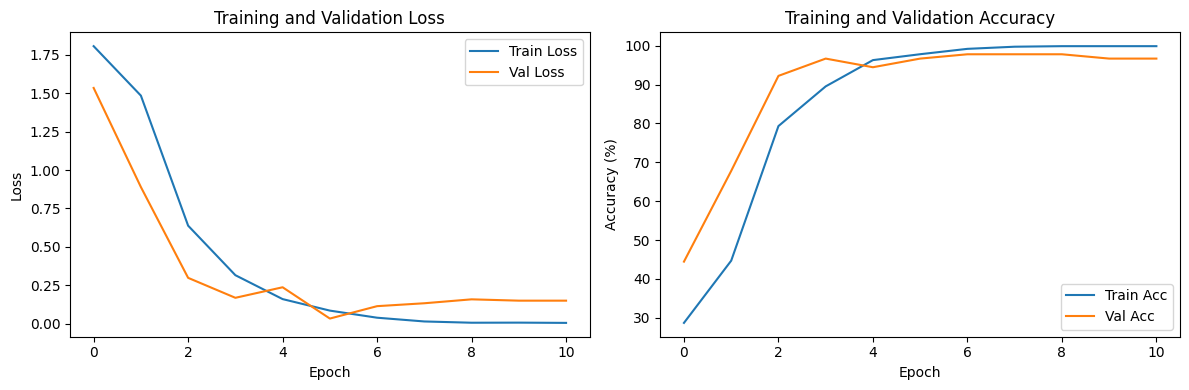

Epoch 11:   0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11: Train Loss: 0.0058, Train Acc: 99.86%, Val Loss: 0.1495, Val Acc: 96.67%


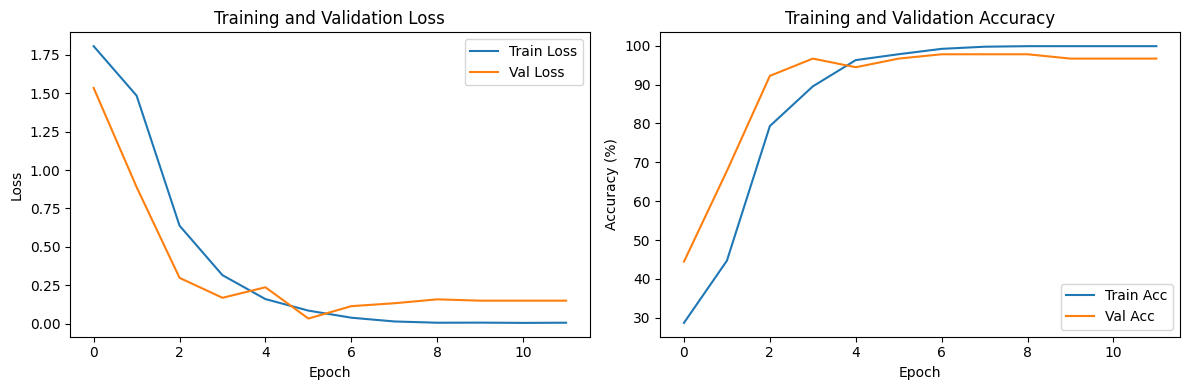

Epoch 12:   0%|          | 0/91 [00:00<?, ?it/s]

Early stopping at epoch 12


In [13]:
model = RegulationsTransformer(num_labels=len(categories), freeze_bert=True)
trainer = TransferLearningTrainer(model=model, dataloaders=dataloaders)


# Fine-tune BERT layers
trainer.fine_tune_bert()
trainer.train(epochs=100)

In [13]:
class RegulationsPredictor:
    def __init__(self, model, tokenizer, categories, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.categories = categories
        self.device = device
        self.model.eval()

    def predict(self, text):
        # Tokenize text
        encoding = self.tokenizer( #Convierte las palabras del texto en tokens, que son representaciones numéricas de las palabras.
        #Agrega tokens especiales (como [CLS] al inicio y [SEP] al final).
        #Asegura que el texto esté en un formato de entrada adecuado para BERT.
            text, # El texto que se va a predecir.
            truncation=True, #se recorte (truncado) a la longitud máxima.
            max_length=512, #maximo BERT tiene un límite de 512 tokens por secuencia de entrada.
            padding='max_length', # Esto garantiza que el texto sea rellenado hasta la longitud máxima de 512 tokens de padding
            return_tensors='pt' #formato compatible con PyTorch (torch.Tensor)
        )

        # Move to device
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad(): #no se calculan gradientes
            outputs = self.model(input_ids, attention_mask) # se pasa la entrada tokenizada (input_ids y attention_mask) a través del modelo entrenado
            #devuelve una serie de salidas que contienen las activaciones de la red. En el caso de un modelo de clasificación,
            #esto típicamente será una matriz de logits (los valores sin normalizar que indican las "probabilidades" sin ser transformadas)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)#cada conjunto de logits de una instancia en el lote se convierte en una distribución de probabilidad
            prediction = torch.argmax(probabilities, dim=1)#La función argmax devuelve el índice del valor máximo a lo largo de la
            # dimensión especificada (dim=1, que corresponde a las clases
            confidence = probabilities[0][prediction].item()#selecciona la probabilidad de la clase predicha para el
            #primer ejemplo en el lote. Dado que generalmente prediction es un tensor de índices

        predicted_category = self.categories[prediction.item()] #se obtiene el nombre de la categoría asociada con la clase predicha

        return {
            'category': predicted_category,
            'confidence': confidence,
            'probabilities': {
                cat: prob.item()
                for cat, prob in zip(self.categories, probabilities[0])
            }
        }

def load_predictor(checkpoint_path, categories, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = RegulationsTransformer(num_labels=len(categories))
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])

    return RegulationsPredictor(model, tokenizer, categories, device)

In [16]:
# Load the predictor with your best model
predictor = load_predictor('/content/drive/MyDrive/SIS421/NLP/CheckpointClasificador/best_model.pt', categories)

# Make predictions
text = "El estudiante debe cumplir con las normas académicas establecidas"
result = predictor.predict(text)

print(f"Predicted category: {result['category']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities for all categories:")
for cat, prob in result['probabilities'].items():
    print(f"{cat}: {prob:.2%}")

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

<ipython-input-13-5486cd9ce277>:44: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Predicted category: Normativa Estudiantil
Confidence: 65.04%

Probabilities for all categories:
Gobierno Universitario: 34.32%
Gestion Administrativa: 0.00%
Investigacion y Docencia: 0.04%
Infraestructura y Recursos: 0.01%
Actividades Complementarias: 0.00%
Normativa Estudiantil: 65.04%
Normativa Academica: 0.59%


In [17]:
text = "El sistema de programación de operaciones permitirá la organización eficiente de los recursos materiales y humanos."
result = predictor.predict(text)

print(f"Predicted category: {result['category']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities for all categories:")
for cat, prob in result['probabilities'].items():
    print(f"{cat}: {prob:.2%}")

Predicted category: Gobierno Universitario
Confidence: 96.38%

Probabilities for all categories:
Gobierno Universitario: 96.38%
Gestion Administrativa: 0.02%
Investigacion y Docencia: 0.00%
Infraestructura y Recursos: 0.00%
Actividades Complementarias: 3.14%
Normativa Estudiantil: 0.44%
Normativa Academica: 0.01%


In [18]:
text = "El régimen de calificaciones establece que cada asignatura contará con evaluaciones parciales y una evaluación final"
result = predictor.predict(text)

print(f"Predicted category: {result['category']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities for all categories:")
for cat, prob in result['probabilities'].items():
    print(f"{cat}: {prob:.2%}")

Predicted category: Gestion Administrativa
Confidence: 90.21%

Probabilities for all categories:
Gobierno Universitario: 2.14%
Gestion Administrativa: 90.21%
Investigacion y Docencia: 1.14%
Infraestructura y Recursos: 4.27%
Actividades Complementarias: 1.43%
Normativa Estudiantil: 0.24%
Normativa Academica: 0.55%


In [19]:
text = "Los requisitos de graduación incluyen la aprobación de un examen de competencias generales y específicas"
result = predictor.predict(text)

print(f"Predicted category: {result['category']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities for all categories:")
for cat, prob in result['probabilities'].items():
    print(f"{cat}: {prob:.2%}")

Predicted category: Infraestructura y Recursos
Confidence: 90.85%

Probabilities for all categories:
Gobierno Universitario: 0.16%
Gestion Administrativa: 3.64%
Investigacion y Docencia: 3.56%
Infraestructura y Recursos: 90.85%
Actividades Complementarias: 0.13%
Normativa Estudiantil: 0.25%
Normativa Academica: 1.41%


In [20]:
text = "La universidad se rige por un modelo académico orientado a la formación integral y la investigación científica aplicada."
result = predictor.predict(text)

print(f"Predicted category: {result['category']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities for all categories:")
for cat, prob in result['probabilities'].items():
    print(f"{cat}: {prob:.2%}")

Predicted category: Normativa Estudiantil
Confidence: 84.54%

Probabilities for all categories:
Gobierno Universitario: 1.87%
Gestion Administrativa: 0.00%
Investigacion y Docencia: 0.04%
Infraestructura y Recursos: 0.01%
Actividades Complementarias: 0.00%
Normativa Estudiantil: 84.54%
Normativa Academica: 13.54%


In [21]:
text = "Las facultades deben presentar un informe semestral de sus actividades administrativas al Consejo Universitario."
result = predictor.predict(text)

print(f"Predicted category: {result['category']}")
print(f"Confidence: {result['confidence']:.2%}")
print("\nProbabilities for all categories:")
for cat, prob in result['probabilities'].items():
    print(f"{cat}: {prob:.2%}")

Predicted category: Gobierno Universitario
Confidence: 51.29%

Probabilities for all categories:
Gobierno Universitario: 51.29%
Gestion Administrativa: 0.01%
Investigacion y Docencia: 0.18%
Infraestructura y Recursos: 0.02%
Actividades Complementarias: 0.04%
Normativa Estudiantil: 48.14%
Normativa Academica: 0.32%
